In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from sklearn.pipeline import Pipeline

import getpass


# yay models
import xgboost as xgb
import graphviz

# used for train/test splits
from sklearn import model_selection

# used to impute mean for data
from sklearn.preprocessing import Imputer

# models to test
import sklearn.linear_model as lm
import sklearn.svm as svm
import sklearn.ensemble as ensemble

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];

%matplotlib inline

In [2]:
# define the equations used
def pao2_nonlinear(s):
    # Severinghaus 1979
    
    # prevent divide by 0 errors
    s = np.where(s ==   0,  0.01, s)
    s = np.where(s == 100, 99.99, s)
    
    # convert input from % to fraction
    s = s / 100.0
    t = 11700 / (1/s - 1)
    
    p1 = t + np.sqrt( 125000 + np.power(t,2))
    idxNeg = p1 < 0
    p1 = np.power(abs(p1), float(1)/3)
    p1 = np.where(idxNeg, -p1, p1)
    
    p2 = t - np.sqrt( 125000 + np.power(t,2))
    idxNeg = p2 < 0
    p2 = np.power(abs(p2), float(1)/3)
    p2 = np.where(idxNeg, -p2, p2)
    
    p = p1 + p2
    
    return p

def pao2_loglinear(s,f):
    # Pandharipande 2009
    
    # calculate log (base 10...) pao2/fio2 ratio
    p = 0.48 + (0.78 * np.log10(s/f))
    
    # convert from log10(pf) to pao2
    p = np.power(10, p) * f
    
    return p

def pao2_loglinear_peep(s,f,peep):
    
    if peep < 8:
        PF = np.power(10, 0.06 + 0.94 * np.log10(s/f)) # < 8
        
    elif peep <= 12:
        PF = np.power(10, -0.13 + 1.01 * np.log10(s/f)) # 8-12
    
    else:
        PF = np.power(10, -0.47 + 1.17 * np.log10(s/f)) # > 12
        
        
    return PF * f
    
    
    
def pao2_linear(s,f):
    # Rice 2007
    
    # calculate log pao2/fio2 ratio
    p = (s/f - 64.0)/0.84
    
    # convert from pf to pao2
    p = p * f
    
    return p

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10


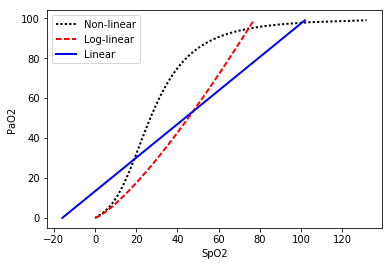

In [3]:
# plot the equations against each other

xi = range(100)

eq1 = [pao2_nonlinear(x) for x in xi]
eq2 = [pao2_loglinear(x, 0.2089) for x in xi]
eq3 = [pao2_linear(x, 0.2089) for x in xi]

plt.figure()
plt.plot(eq1, xi, linestyle=':',linewidth=2,color='black')
plt.plot(eq2, xi, linestyle='--',linewidth=2,color='red')
plt.plot(eq3, xi, linestyle='-',linewidth=2,color='blue')

plt.xlabel('SpO2')
plt.ylabel('PaO2')
plt.legend(['Non-linear','Log-linear','Linear'], loc='best')
plt.show()

In [35]:
# create a database connection
SQL = False

if SQL:
    # first you need to create a tunnel in a terminal session
    print('Run the following in a terminal:\nssh -L5647:hera:5432 alistairewj@prometheus -N\n')

    # below config used on pc70
    sqluser = 'alistairewj'
    sqlhost = 'localhost'
    sqlport = 5647
    dbname = 'eicu'
    schema_name = 'eicu_crd_phi'

    print('Username: {}'.format(sqluser))
    sqlpass = getpass.getpass('Password: ')

    # the below is appended to queries to make them work
    query_schema = 'set search_path to public,' + schema_name + ';'

    # Connect to postgres DB with eicu
    con = psycopg2.connect(dbname=dbname,
                           host=sqlhost, port=sqlport,
                           user=sqluser, password=sqlpass)

    # load the data

    query = query_schema + """
    select * from pf_data;
    """
    #df = pd.read_sql_query(query,con)
    df = pd.read_csv('pao2-model.csv.gz', compression='gzip')

    # set columns to lower case
    df.columns = [x.lower() for x in df.columns]
    df.describe()

    con.close()
else:
    # \copy (select * from pf_data) to 'pf_data.csv' CSV HEADER;
    df = pd.read_csv('pf_data.csv', dtype={'peep': str})
    
    # fix peep - there's a string "Date\Time Correction"
    df['peep'] = pd.to_numeric(df['peep'], errors='coerce')

Data is:

* every pao2/fio2 value from the lab table, using only fio2 from the lab table
* the last recorded vital sign from the prior 6 hours
* the last recorded lab from the prior 24 hours
* the last recorded peep from the prior 4 hours
* whether the patient is mechanically ventilated or not

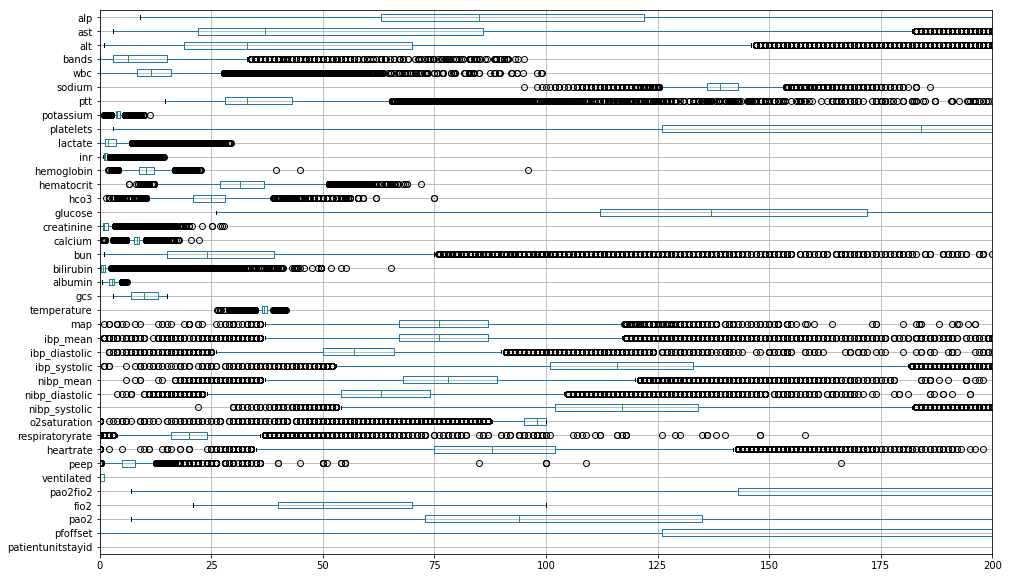

In [52]:
# create a box plot of our data
# there is some bug with the date type being different in python/pandas
# it messes up the boxplot function
# so we extract the data with only the names
# this removes charttime which was causing us trouble
#df0 = pd.DataFrame.from_records(df, columns=X_names)

plt.figure(figsize=[16,10])
df.boxplot(return_type='axes', vert=False)
ax = plt.gca()
ax.set_xlim([0,200])
plt.show()

In [67]:
# filter out bad data
idxIgnore = np.any([df.fio2.values < 20, df.fio2.values > 100], axis=0)
print('Removing {} rows with bad FiO2.'.format(np.sum(idxIgnore)))
# extract data
y = df.pao2.values
X_names = ['o2saturation', 'fio2']

# create an iterator to get index of these names
X_header = [df.columns[i] for i in range(df.columns.values.size) if df.columns[i] in X_names]

# get feature/predictor matrix as numpy array
X = df.loc[:, X_header].values
X = X[~idxIgnore,:]
y = y[~idxIgnore]


idxIgnore = np.any(np.isnan(X), axis=1)
print('Removing {} ({:5.2f}%) rows with missing data (usually o2 sat).'.format(
        np.sum(idxIgnore), np.mean(idxIgnore)*100.0))
X = X[~idxIgnore,:]
y = y[~idxIgnore]

Removing 0 rows with bad FiO2.
Removing 88166 (38.26%) rows with missing data (usually o2 sat).


In [56]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=0)

RMSE: 63.56333819


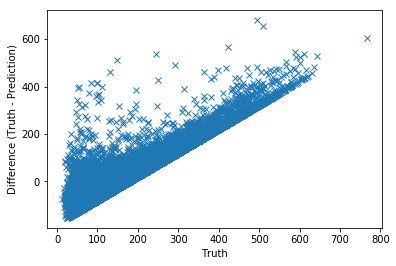

In [57]:
# try a linear regression
model = lm.LinearRegression(fit_intercept=True)
model.fit(X_train,y_train)

yhat_lr = model.predict(X_test)
print('RMSE: {}').format( np.sqrt( np.mean( np.square(yhat_lr - y_test) ) ) )

plt.figure()
plt.plot(y_test, y_test-yhat_lr, linestyle='none',marker='x')
plt.xlabel('Truth')
plt.ylabel('Difference (Truth - Prediction)')
plt.show()

# would be nice to see the plot with mini BoxPlots @ 50, 100, 150, 200, etc instead of a bunch of points

In [58]:
def try_xgboost(X_train, y_train, X_test, y_test, feature_names=X_header):
    # try xgboost
    dtrain = xgb.DMatrix( X_train, label=y_train, feature_names=X_header)
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_header)

    # parameters
    param = {'silent':1,
             #'bst:eta':1,
             'objective':'reg:linear'}
    param['nthread'] = 4

    bst = xgb.train( param, dtrain, 10 )
    
    yhat = bst.predict(dtest)
    return [yhat, bst]
    
def try_lr(X_train, y_train, X_test, y_test, feature_names=X_header):
    # try xgboost
    model = lm.LinearRegression(fit_intercept=True)
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    
    return yhat

In [59]:
# try xgboost
dtrain = xgb.DMatrix( X_train, label=y_train, feature_names=X_header)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_header)

# parameters
param = {'silent':1,
         #'bst:eta':1,
         'objective':'reg:linear'}
param['nthread'] = 4

bst = xgb.train( param, dtrain, 10 )

# bst.save_model('pafi-xgboost-0001.model')

RMSE: 57.7880511232


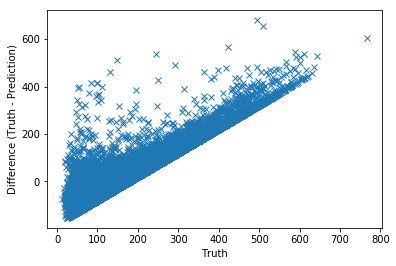

In [60]:
yhat_xg = bst.predict(dtest)
print('RMSE: {}').format( np.sqrt( np.mean( np.square(yhat_xg - y_test) ) ) )

plt.figure()
plt.plot(y_test, y_test-yhat_lr, linestyle='none',marker='x')
plt.xlabel('Truth')
plt.ylabel('Difference (Truth - Prediction)')
plt.show()

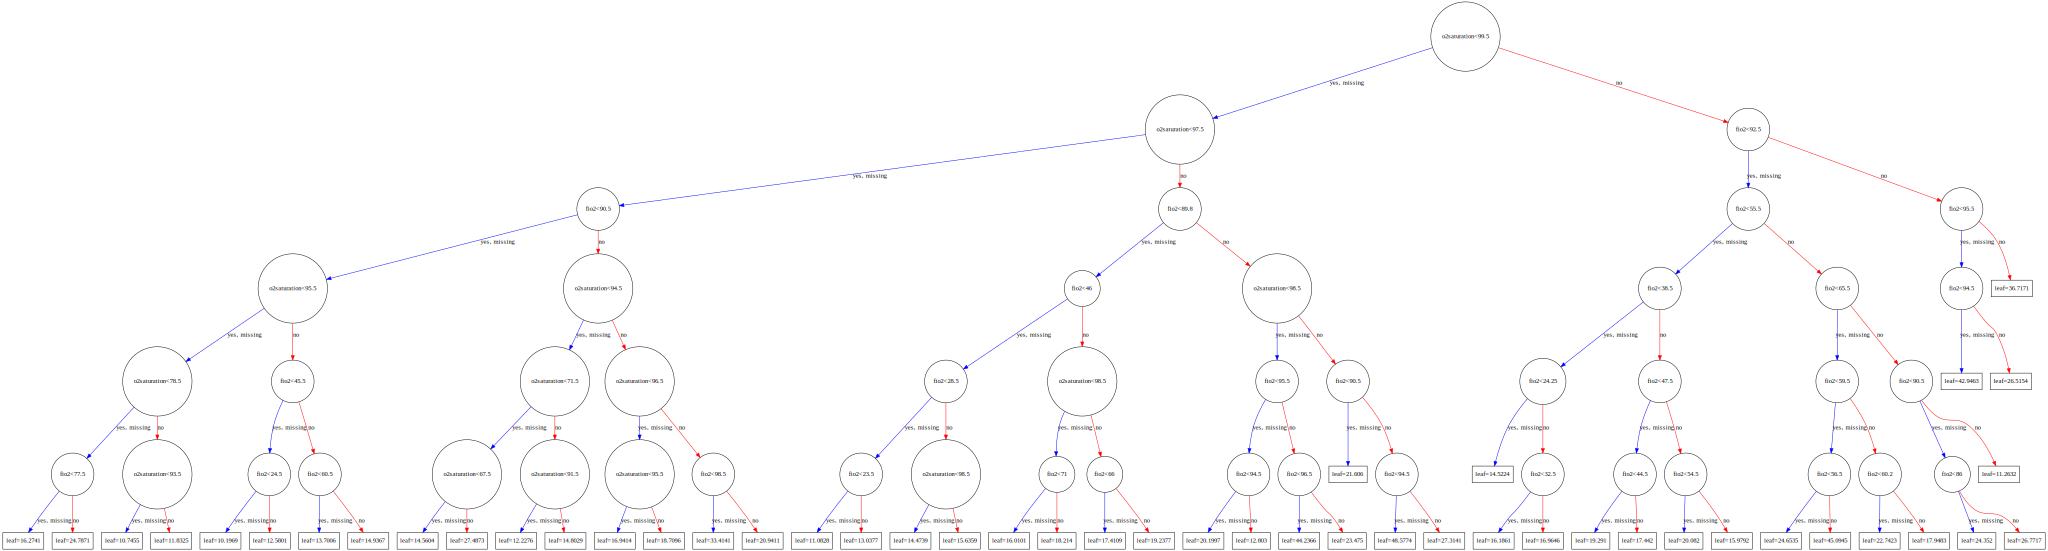

In [61]:
xgb.to_graphviz(bst, num_trees=2)

# Patients with SpO2 <= 96

In [70]:
# filter out bad data
idxIgnore = np.any([df.fio2.values < 20, df.fio2.values > 100, df.o2saturation.values > 96], axis=0)
print('Removing {} rows with bad FiO2 or O2 sat > 96.'.format(np.sum(idxIgnore)))
# extract data
y = df.pao2.values
X_names = ['o2saturation', 'fio2']

# create an iterator to get index of these names
X_header = [df.columns[i] for i in range(df.columns.values.size) if df.columns[i] in X_names]

# get feature/predictor matrix as numpy array
X = df.loc[:, X_header].values
X = X[~idxIgnore,:]
y = y[~idxIgnore]


idxIgnore = np.any(np.isnan(X), axis=1)
print('Removing {} ({:5.2f}%) rows with missing data (usually o2 sat).'.format(
        np.sum(idxIgnore), np.mean(idxIgnore)*100.0))
X = X[~idxIgnore,:]
y = y[~idxIgnore]

# Add in the interaction term
z = X[:, X_header.index('o2saturation')] / X[:, X_header.index('fio2')]
X = np.column_stack([X, z])
X_header.extend(['spo2fio2'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.5, random_state=0)

Removing 92349 rows with bad FiO2 or O2 sat > 96.
Removing 88166 (63.86%) rows with missing data (usually o2 sat).


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


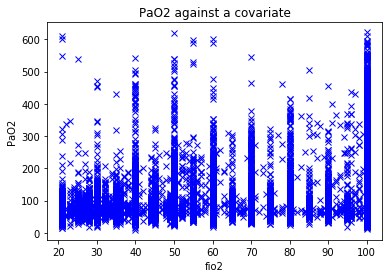

In [71]:
# visualize some of the relationships
idx = 0
plt.figure()
plt.plot(X[:,idx], y, linestyle='none',marker='x',color='b')
plt.xlabel(X_header[idx])
plt.ylabel('PaO2')
plt.title('PaO2 against a covariate')
plt.show()

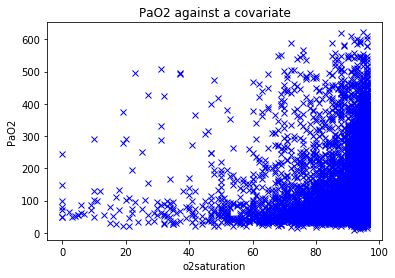

In [72]:
# visualize some of the relationships
idx = 1
plt.figure()
plt.plot(X[:,idx], y, linestyle='none',marker='x',color='b')
plt.xlabel(X_header[idx])
plt.ylabel('PaO2')
plt.title('PaO2 against a covariate')
plt.show()

RMSE: 49.4330581929


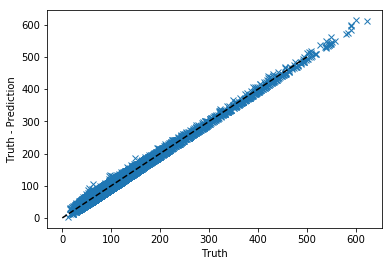

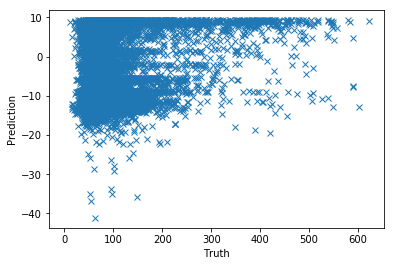

In [81]:
# try a linear regression
model = lm.LinearRegression(fit_intercept=True)
model.fit(X_train,y_train)

yhat_lr = model.predict(X_test)
print('RMSE: {}').format( np.sqrt( np.mean( np.square(yhat_lr - y_test) ) ) )

plt.figure()
plt.plot(y_test, y_test - yhat_lr + 90, linestyle='none',marker='x')
plt.plot([0,500], [0,500], linestyle='--',color='black')
plt.xlabel('Truth')
plt.ylabel('Truth - Prediction')
plt.show()


plt.figure()
plt.plot(y_test, yhat_lr - 90, linestyle='none',marker='x')
plt.plot([0,0], [0,0], linestyle='--',color='black')
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

# would be nice to see the plot with mini BoxPlots @ 50, 100, 150, 200, etc instead of a bunch of points

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10


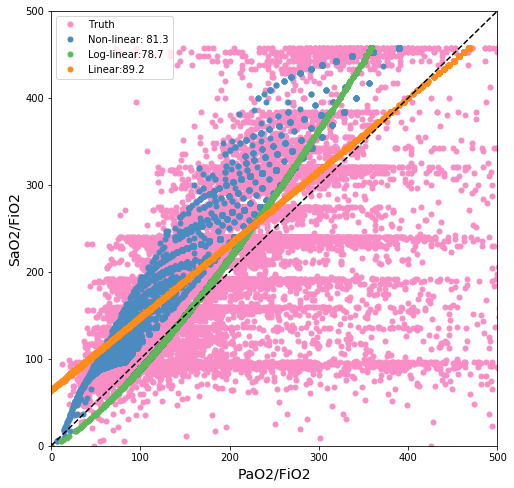

In [84]:
# reproduce the Rice2007 plot
sao2 = X_test[:, X_header.index('o2saturation')]
fio2 = X_test[:, X_header.index('fio2')] / 100
sf = sao2 / fio2
pf = y_test / fio2


# use their linear equation
pf1 = pao2_nonlinear(sao2) / fio2
pf2 = pao2_loglinear(sao2,fio2) / fio2
pf3 = pao2_linear(sao2,fio2) / fio2

plt.figure(figsize=(8,8))
plt.plot(pf,  sf, linestyle='none',marker='.',linewidth=2,markersize=10,color=col[6])
plt.plot(pf1, sf, linestyle='none',marker='.',linewidth=2,markersize=10,color=col[1])
plt.plot(pf2, sf, linestyle='none',marker='.',linewidth=2,markersize=10,color=col[2])
plt.plot(pf3, sf, linestyle='none',marker='.',linewidth=2,markersize=10,color=col[3])

plt.plot([0,500], [0,500], linestyle='--',color='black')
plt.xlabel('PaO2/FiO2',fontsize=14)
plt.ylabel('SaO2/FiO2',fontsize=14)


plt.legend(['Truth',
            'Non-linear: ' + "%2.1f" % np.sqrt ( ( np.square(pf1-pf) ).mean() ),
            'Log-linear:' + "%2.1f" % np.sqrt ( ( np.square(pf2-pf) ).mean() ),
            'Linear:' + "%2.1f" % np.sqrt ( ( np.square(pf3-pf) ).mean() )],loc='best')
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [ ]:
# plot PaO2/FiO2 (truth) against the predictions

# add some jitter
def add_jitter(x):
    stdev = .01*(max(x)-min(x))
    return x + np.random.randn(len(x)) * stdev

def jitter(x, y, markersize=10, color='b', marker='o', linewidth=2, **kwargs):
    return plt.plot(add_jitter(x), add_jitter(y), markersize=markersize, color=color, marker=marker, linewidth=linewidth, **kwargs)

plt.figure(figsize=(12,12))
jitter(pf, pf3, linestyle='none',marker='.',linewidth=2,markersize=10,color=col[0])
jitter(pf, pf2, linestyle='none',marker='.',linewidth=2,markersize=10,color=col[1])
jitter(pf, pf1, linestyle='none',marker='.',linewidth=2,markersize=10,color=col[2])
jitter(pf, pf_pred, linestyle='none',marker='.',linewidth=2,markersize=10,color=col[3])

plt.plot([0,500], [0,500], linestyle='--',color='black')
plt.xlabel('PaO2/FiO2 (truth)',fontsize=14)
plt.ylabel('PaO2/FiO2 (predicted)',fontsize=14)


plt.legend(['Linear:' + "%2.1f" % np.sqrt ( ( np.square(pf3-pf) ).mean() ),
            'Log-linear:' + "%2.1f" % np.sqrt ( ( np.square(pf2-pf) ).mean() ),
            'Non-linear: ' + "%2.1f" % np.sqrt ( ( np.square(pf1-pf) ).mean() ),
            'Prediction:' + '%2.1f' % np.sqrt( ( np.square(pf_pred-pf) ).mean())],loc='best')
plt.xlim([0,500])
plt.ylim([0,500])
plt.show()

In [88]:

# reproduce the Rice2007 plot
sao2 = X_test[:, X_header.index('o2saturation')]
fio2 = X_test[:, X_header.index('fio2')] / 100
sf = sao2 / fio2
pf = y_test / fio2

pf_pred = model.predict(X_test)

# use their linear equation
pf1 = pao2_nonlinear(sao2) / fio2
pf2 = pao2_loglinear(sao2,fio2) / fio2
pf3 = pao2_linear(sao2,fio2) / fio2


pf_all = np.column_stack([pf3, pf2, pf1, pf_pred])
pf_header = ['Linear:' + "%2.1f" % np.sqrt ( ( np.square(pf3-pf) ).mean() ),
            'Log-linear:' + "%2.1f" % np.sqrt ( ( np.square(pf2-pf) ).mean() ),
            'Non-linear: ' + "%2.1f" % np.sqrt ( ( np.square(pf1-pf) ).mean() ),
            'Prediction:' + '%2.1f' % np.sqrt( ( np.square(pf_pred-pf) ).mean())]

# initialize the locations of each box
pf_grp = np.asarray(range(20))*20+20

# initialize the values of the box plot
pf_mu = np.zeros( [ pf_grp.size, pf_all.shape[1] ] )
pf_med = np.zeros( [ pf_grp.size, pf_all.shape[1] ] )
pf_25 = np.zeros( [ pf_grp.size, pf_all.shape[1] ] )
pf_75 = np.zeros( [ pf_grp.size, pf_all.shape[1] ] )
pf_iqr = np.zeros( [ pf_grp.size, pf_all.shape[1] ] )
pf_min = np.zeros( [ pf_grp.size, pf_all.shape[1] ] )
pf_max = np.zeros( [ pf_grp.size, pf_all.shape[1] ] )

for i in range(pf_grp.size-1):
    for p in range(pf_all.shape[1]):
        tmp = pf_all[:,p]
        tmp = tmp[ (pf >= pf_grp[i]) & (pf < pf_grp[i+1]) ]
        tmp = tmp[ ~np.isnan(tmp)]
        if tmp.size > 1:
            pf_mu[i,p] = np.mean(tmp)
            pf_med[i,p] = np.median(tmp)
            pf_25[i,p] = np.percentile(tmp,25)
            pf_75[i,p] = np.percentile(tmp,75)
            pf_iqr[i,p] = np.percentile(tmp,75) - np.percentile(tmp,25)
            pf_min[i,p] = np.min(tmp)
            pf_max[i,p] = np.max(tmp)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10


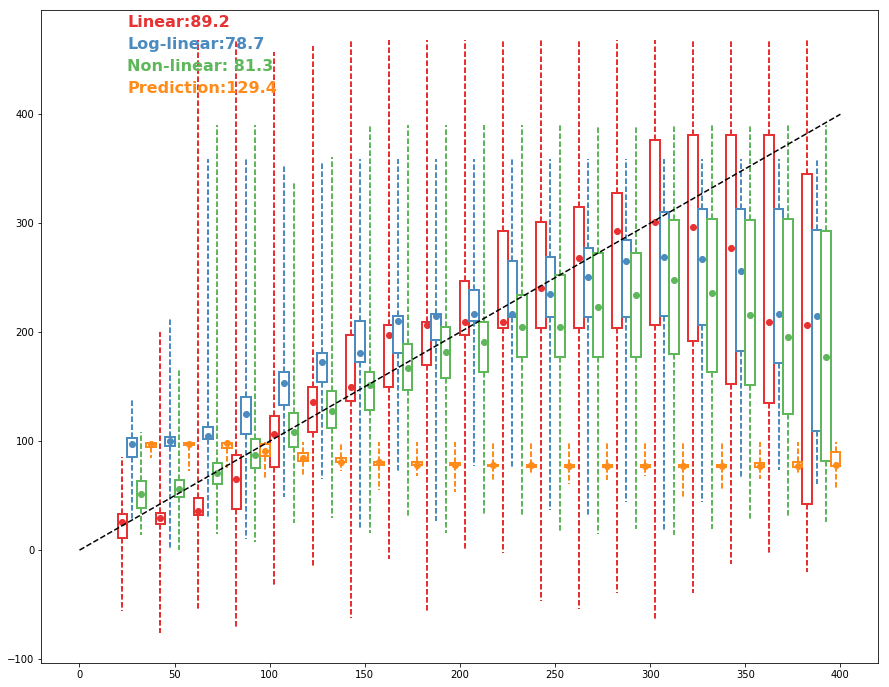

In [89]:
plt.figure(figsize=[15,12])

p=0
P = pf_all.shape[1] # number of boxplots
boxWidth = (pf_grp[1] - pf_grp[0]) * 1/P 

for p in range(P):
    for i in range(pf_grp.size - 1):

        boxStart =  pf_grp[i] + p*boxWidth
        boxEnd = pf_grp[i] + (p+1)*boxWidth
        boxMed = (boxEnd - boxStart)/2.0 + boxStart

        # horizontal lines
        plt.plot( [boxStart, boxEnd], [pf_25[i,p], pf_25[i,p]], color=col[p], linewidth=2 )
        plt.plot( [boxStart, boxEnd], [pf_75[i,p], pf_75[i,p]], color=col[p], linewidth=2 )

        # vertical lines
        plt.plot( [boxStart, boxStart], [pf_25[i,p], pf_75[i,p]], color=col[p], linewidth=2 )
        plt.plot( [boxEnd, boxEnd], [pf_25[i,p], pf_75[i,p]], color=col[p], linewidth=2 )

        # medians
        plt.plot( boxMed, pf_med[i,p], color=col[p], linewidth=2, marker='o' )

        # whiskers (option 1)
        #plt.plot( [medLoc, medLoc], [pf_75[i,p], pf_75[i,p]+pf_iqr[i,p]*1.5], color=col[p], linewidth=2, linestyle='--' )
        #plt.plot( [medLoc, medLoc], [pf_25[i,p]-pf_iqr[i,p]*1.5, pf_25[i,p]], color=col[p], linewidth=2, linestyle='--' )

        # whiskers (option 2)
        plt.plot( [boxMed, boxMed], [pf_75[i,p], pf_max[i,p]], color=col[p], linewidth=2, linestyle='--' )
        plt.plot( [boxMed, boxMed], [pf_25[i,p], pf_min[i,p]], color=col[p], linewidth=2, linestyle='--' )

    plt.text(25, 480 - p*20, pf_header[p], color=col[p],fontsize=16, fontweight='bold')
    
plt.plot([0,400],[0,400],linestyle='--',linewidth=1.5, color='black')

plt.show()

In [107]:
def make_boxplot(pf, pf_dict):
    # add in the elements from the dictionary
    header = pf_dict.keys()
    pf_header = [ hdr + ': ' + "%2.1f" % np.sqrt ( ( np.square(pf_dict[hdr]-pf) ).mean() )
             for n, hdr in enumerate(header)]
    
    P = len(header)
    
    # initialize the locations of each box
    pf_grp = (np.asarray(range(30))+1)*15
    G = pf_grp.size-1 # number of groups of PaO2/FiO2

    # initialize the values of the box plot
    pf_mu = np.zeros( [ G, P ] )
    pf_med = np.zeros( [ G, P ] )
    pf_25 = np.zeros( [ G, P ] )
    pf_75 = np.zeros( [ G, P ] )
    pf_iqr = np.zeros( [ G, P ] )
    pf_min = np.zeros( [ G, P ] )
    pf_max = np.zeros( [ G, P ] )
    # number of observations
    pf_num = np.zeros( [ G, P ] )

    for i in range(G):
        for p in range(P):
            tmp = pf_dict[header[p]]
            tmp = tmp[ (pf >= pf_grp[i]) & (pf < pf_grp[i+1]) ]
            tmp = tmp[ ~np.isnan(tmp)]
            pf_num[i,p] = tmp.size 
            if tmp.size > 1:
                pf_mu[i,p] = np.mean(tmp)
                pf_med[i,p] = np.median(tmp)
                pf_25[i,p] = np.percentile(tmp,25)
                pf_75[i,p] = np.percentile(tmp,75)
                pf_iqr[i,p] = np.percentile(tmp,75) - np.percentile(tmp,25)
                pf_min[i,p] = np.min(tmp)
                pf_max[i,p] = np.max(tmp)

    # create axis which is middle of the bar
    pf_plt = [ pf_grp[i] + (pf_grp[i+1] - pf_grp[i]) / 2 for i in range(pf_grp.size-1) ]
    
    #================ NORMAL PLOT =======================#
    plt.figure(figsize=[15,12])

    boxWidth = (pf_grp[1] - pf_grp[0]) * 1/P 


    for p in range(P):
        plt.plot( pf_plt, pf_med[:,p], color=col[p], linewidth=2, linestyle='-' )


    #plt.plot( pf_plt, pf_num[:,0], color=col[7], linewidth=2, linestyle='-')


    #for i in range(G):
    #    plt.text( pf_plt[i], -80 + 5*i, '%5g' % pf_num[i,0], color=col[7], fontsize=14, fontweight='bold')
    #for p in range(P):
    #    plt.plot( pf_grp, pf_25[:,p], color=col[p], linewidth=1.5, linestyle='--' )
    #    plt.plot( pf_grp, pf_75[:,p], color=col[p], linewidth=1.5, linestyle='--' )
    #    plt.plot( pf_grp, pf_min[:,p], color=col[p], linewidth=1.5, linestyle=':' )
    #    plt.plot( pf_grp, pf_max[:,p], color=col[p], linewidth=1.5, linestyle=':' )

    plt.plot([0,400],[0,400],linestyle='--',linewidth=1.5, color='black')

    plt.legend(pf_header, loc='best')
    plt.xlabel('PaO2/FiO2 (truth)',fontsize=14)
    plt.ylabel('PaO2/FiO2 (predicted)',fontsize=14)
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10


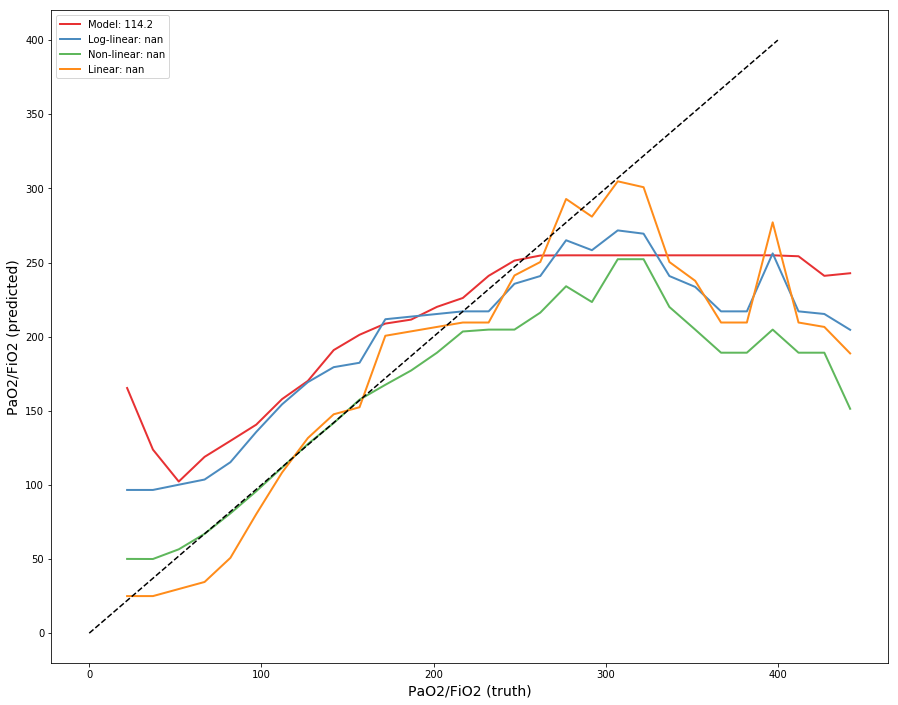

In [108]:
# filter out bad data and SpO2s > 96
idxIgnore = np.any([df.fio2.values < 20, df.fio2.values > 100, df.o2saturation.values > 96], axis=0)

# extract data
y = df.pao2[~idxIgnore].values
X_names = ['o2saturation', 'fio2', 'ventilation','peep']

# create an iterator to get index of these names
X_header = [df.columns[i] for i in range(df.columns.values.size) if df.columns[i] in X_names]

# get feature/predictor matrix as numpy array
X = df.loc[:, X_header].values
X = X[~idxIgnore,:]

# Add in the sao2/fio2
z = X[:, X_header.index('o2saturation')] / X[:, X_header.index('fio2')]
X = np.column_stack([X, z])
X_header.extend(['sao2fio2'])

# Add in the predicted pao2 from the non-linear equation
z = pao2_nonlinear(X[:, X_header.index('o2saturation')]) # / X[:, X_header.index('fio2')]
X = np.column_stack([X, z])
X_header.extend(['pao2_nonlinear'])

## Add in the predicted pao2/fio2 from the non-linear equation
#z = pao2_nonlinear(X[:, X_header.index('sao2')])  / X[:, X_header.index('fio2')]
#X = np.column_stack([X, z])
#X_header.extend(['pao2fio2_nonlinear'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.5, random_state=0)
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_train)

# using the fixed equations (linear/loglinear/nonlinear), calculate the pao2
sao2 = X_test[:, X_header.index('o2saturation')]
fio2 = X_test[:, X_header.index('fio2')] / 100

pf1 = pao2_nonlinear(sao2) / fio2
pf2 = pao2_loglinear(sao2,fio2) / fio2
pf3 = pao2_linear(sao2,fio2) / fio2

# ground truth
sf = sao2 / fio2
pf = y_test / fio2


# train model

fio2_train = X_train[:, X_header.index('fio2')] / 100
yhat_xg = try_xgboost(imp.transform(X_train), y_train, imp.transform(X_test), y_test, feature_names=X_header)
pf_pred = yhat_xg[0] / fio2

#============ CREATE DATA FOR PLOTS ====================#
pf_dict = {'Linear': pf3,
          'Log-linear': pf2,
          'Non-linear': pf1,
          'Model': pf_pred}

make_boxplot(pf, pf_dict)

In [ ]:
#xgb_fig = xgb.to_graphviz(bst, num_trees=2)
#xgb_fig.render(filename='xgb_graph', view=True) # view in pdf reader

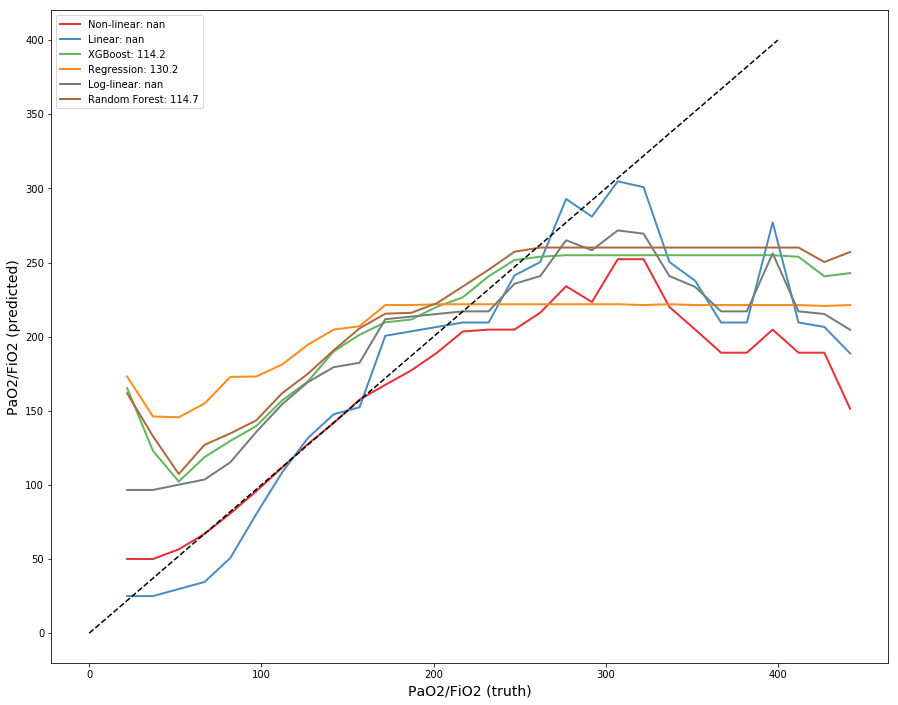

In [110]:
# filter out bad data and SpO2s > 96
idxIgnore = np.any([df.fio2.values < 20, df.fio2.values > 100, df.o2saturation.values > 96], axis=0)

# extract data
y = df.pao2[~idxIgnore].values
X_names = ['o2saturation', 'fio2', 'ventilation','peep']

# create an iterator to get index of these names
X_header = [df.columns[i] for i in range(df.columns.values.size) if df.columns[i] in X_names]

# get feature/predictor matrix as numpy array
X = df.loc[:, X_header].values
X = X[~idxIgnore,:]


# Add in the sao2/fio2
z = X[:, X_header.index('o2saturation')] / X[:, X_header.index('fio2')]
X = np.column_stack([X, z])
X_header.extend(['sao2fio2'])

## Add in the predicted pao2/fio2 from the non-linear equation
#z = pao2_nonlinear(X[:, X_header.index('sao2')])  / X[:, X_header.index('fio2')]
#X = np.column_stack([X, z])
#X_header.extend(['pao2fio2_nonlinear'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.5, random_state=0)
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_train)

# using the fixed equations (linear/loglinear/nonlinear), calculate the pao2
sao2 = X_test[:, X_header.index('o2saturation')]
fio2 = X_test[:, X_header.index('fio2')] / 100

pf1 = pao2_nonlinear(sao2) / fio2
pf2 = pao2_loglinear(sao2,fio2) / fio2
pf3 = pao2_linear(sao2,fio2) / fio2

# ground truth
sf = sao2 / fio2
pf = y_test / fio2

#============ BUILD PREDICTIVE MODEL ===============#
rf = ensemble.RandomForestRegressor(n_estimators=500, max_depth=None,
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                    max_features=2, max_leaf_nodes=None, bootstrap=True,
                                    oob_score=False, n_jobs=1, random_state=None,
                                    verbose=0, warm_start=False)
rf.fit( imp.transform(X_train) , y_train )
yhat = rf.predict(imp.transform(X_test))
rf_pred = yhat / fio2


# linear regression
model = lm.LinearRegression(fit_intercept=True)
model.fit( imp.transform(X_train) , y_train )
yhat = model.predict(imp.transform(X_test))
lr_pred = yhat / fio2

# xgboost
yhat_xg, bst = try_xgboost(imp.transform(X_train), y_train, imp.transform(X_test), y_test,
                      feature_names=X_header)
xg_pred = yhat_xg / fio2

#============ CREATE DATA FOR PLOTS ====================#
pf_dict = {'Linear': pf3,
          'Log-linear': pf2,
          'Non-linear': pf1,
          'Regression': lr_pred,
          'Random Forest': rf_pred,
          'XGBoost': xg_pred}

make_boxplot(pf, pf_dict)